<div style="text-align: center; padding: 2em 1em; background: linear-gradient(135deg, #f093fb 0%, #f5576c 100%); border-radius: 12px; color: white; margin-bottom: 2em;">
  <h1 style="margin: 0; font-size: 2.5em; font-weight: 600; letter-spacing: -0.02em;">Метрики монетизации (Monetization Metrics)</h1>
  <p style="margin: 0.5em 0 0 0; font-size: 1.2em; opacity: 0.95;">Полное руководство по метрикам монетизации в играх</p>
</div>

<div style="padding: 1.5em; background: #f8f9fa; border-left: 4px solid #f5576c; border-radius: 6px; margin: 1em 0;">
  <p style="margin: 0; color: #2c3e50; line-height: 1.6; font-weight: 400;">
    <strong>Monetization (монетизация)</strong> — метрики, показывающие насколько эффективно игра зарабатывает деньги.
    Эти метрики критически важны для оценки жизнеспособности продукта и принятия бизнес-решений.
    Правильная монетизация балансирует между доходом и user experience, не разрушая вовлеченность и retention.
  </p>
</div>


In [1]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings

warnings.filterwarnings('ignore')

# Настройка стиля графиков
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ Библиотеки загружены успешно")


✓ Библиотеки загружены успешно


## Генерация синтетических данных

Для демонстрации всех метрик создадим синтетический датасет с пользователями и их покупками.


In [2]:
# Устанавливаем seed для воспроизводимости
np.random.seed(42)

# Параметры датасета
n_users = 10000  # Количество пользователей
start_date = datetime(2024, 1, 1)
end_date = datetime(2024, 3, 31)  # 3 месяца данных

# Создаем пользователей с разными профилями
user_profiles = ['non_payer', 'minnow', 'dolphin', 'whale']
# Реалистичное распределение: большинство не платят, немного китов
profile_distribution = [0.95, 0.03, 0.015, 0.005]  # ~95% non-payers, ~5% payers

users_data = []
for user_id in range(n_users):
    profile = np.random.choice(user_profiles, p=profile_distribution)
    install_date = start_date + timedelta(days=np.random.randint(0, 60))
    
    users_data.append({
        'user_id': f'user_{user_id:05d}',
        'profile': profile,
        'install_date': install_date,
        'country': np.random.choice(['US', 'EU', 'JP', 'KR', 'CN', 'BR', 'RU'], 
                                   p=[0.25, 0.20, 0.15, 0.10, 0.10, 0.10, 0.10])
    })

users_df = pd.DataFrame(users_data)

# Генерируем покупки для пользователей
purchases = []
purchase_id_counter = 0

# Типы покупок с разными ценами
purchase_types = {
    'starter_pack': {'price': 0.99, 'weight': 0.30},
    'small_gems': {'price': 1.99, 'weight': 0.25},
    'medium_gems': {'price': 4.99, 'weight': 0.20},
    'large_gems': {'price': 9.99, 'weight': 0.15},
    'mega_pack': {'price': 19.99, 'weight': 0.07},
    'ultimate_pack': {'price': 49.99, 'weight': 0.03}
}

purchase_type_names = list(purchase_types.keys())
purchase_weights = [v['weight'] for v in purchase_types.values()]

for idx, user in users_df.iterrows():
    user_id = user['user_id']
    profile = user['profile']
    install_date = user['install_date']
    
    if profile == 'non_payer':
        continue  # Не генерируем покупки для non-payers
    
    # Параметры в зависимости от профиля
    if profile == 'whale':
        num_purchases = np.random.randint(20, 100)  # Много покупок
        purchase_prob_multiplier = 3.0  # Больше склонность к дорогим покупкам
        days_to_first_purchase = np.random.randint(0, 3)  # Быстро начинают платить
    elif profile == 'dolphin':
        num_purchases = np.random.randint(5, 20)
        purchase_prob_multiplier = 1.5
        days_to_first_purchase = np.random.randint(1, 7)
    else:  # minnow
        num_purchases = np.random.randint(1, 5)
        purchase_prob_multiplier = 0.5
        days_to_first_purchase = np.random.randint(3, 14)
    
    # Первая покупка
    first_purchase_date = install_date + timedelta(days=days_to_first_purchase)
    if first_purchase_date > end_date:
        continue
    
    # Генерируем покупки
    for i in range(num_purchases):
        purchase_id_counter += 1
        
        # Дата покупки (распределены во времени после первой покупки)
        if i == 0:
            purchase_date = first_purchase_date
        else:
            days_since_first = np.random.exponential(scale=7)  # В среднем раз в неделю
            purchase_date = first_purchase_date + timedelta(days=int(days_since_first))
        
        if purchase_date > end_date:
            break
        
        # Выбираем тип покупки с учетом профиля
        adjusted_weights = np.array(purchase_weights) ** (1/purchase_prob_multiplier)
        adjusted_weights = adjusted_weights / adjusted_weights.sum()
        
        purchase_type = np.random.choice(purchase_type_names, p=adjusted_weights)
        price = purchase_types[purchase_type]['price']
        
        # Добавляем небольшой шум к цене (промо, скидки)
        if np.random.random() < 0.1:  # 10% шанс на скидку
            price *= np.random.uniform(0.7, 0.95)
        
        purchases.append({
            'purchase_id': f'purchase_{purchase_id_counter:07d}',
            'user_id': user_id,
            'purchase_date': purchase_date,
            'purchase_type': purchase_type,
            'amount_usd': round(price, 2),
            'profile': profile,
            'days_since_install': (purchase_date - install_date).days
        })

purchases_df = pd.DataFrame(purchases)

print(f"✓ Создано {len(users_df)} пользователей")
print(f"✓ Сгенерировано {len(purchases_df)} покупок")
print(f"\nРаспределение пользователей по профилям:")
print(users_df['profile'].value_counts())
print(f"\nПлательщиков: {users_df[users_df['profile'] != 'non_payer'].shape[0]} "
      f"({users_df[users_df['profile'] != 'non_payer'].shape[0] / len(users_df) * 100:.2f}%)")
print(f"\nПример данных покупок:")
print(purchases_df.head(10))


✓ Создано 10000 пользователей
✓ Сгенерировано 5650 покупок

Распределение пользователей по профилям:
profile
non_payer    9497
minnow        297
dolphin       151
whale          55
Name: count, dtype: int64

Плательщиков: 503 (5.03%)

Пример данных покупок:
        purchase_id     user_id purchase_date purchase_type  amount_usd  \
0  purchase_0000001  user_00009    2024-01-28   medium_gems        4.99   
1  purchase_0000002  user_00009    2024-02-03    large_gems        9.99   
2  purchase_0000003  user_00011    2024-02-27    small_gems        1.99   
3  purchase_0000004  user_00011    2024-02-29    small_gems        1.99   
4  purchase_0000005  user_00011    2024-02-28  starter_pack        0.99   
5  purchase_0000006  user_00011    2024-03-05     mega_pack       19.99   
6  purchase_0000007  user_00011    2024-03-10   medium_gems        3.62   
7  purchase_0000008  user_00011    2024-03-03    small_gems        1.99   
8  purchase_0000009  user_00011    2024-03-02   medium_gems        

<div style="padding: 1.5em; background: #ffffff; border-radius: 8px; margin: 1em 0; border-left: 4px solid #f5576c;">
  <h2 style="margin: 0 0 0.5em 0; color: #212529; font-size: 1.8em; font-weight: 600;">1. Revenue (Выручка) и ARPU</h2>
</div>

### 📍 Определение Revenue

**Revenue (Выручка)** — общая сумма денег, полученная от игры за определенный период.

### 📍 Определение ARPU

**ARPU (Average Revenue Per User)** — средняя выручка на одного пользователя.

### 📍 Формулы расчета

$$
\text{Revenue} = \sum \text{Все платежи за период}
$$

$$
\text{ARPU} = \frac{\text{Revenue}}{\text{Количество пользователей}}
$$

**Важно:** В ARPU включаются ВСЕ пользователи, включая тех, кто не платил.

### 📍 Зачем нужны метрики

**Revenue:**
1. **Основная бизнес-метрика**
   - Показывает общий масштаб бизнеса
   - Используется для финансовой отчетности
   - Ключевой KPI для инвесторов

2. **Оценка эффективности**
   - Результат всех действий команды
   - Показывает влияние обновлений

**ARPU:**
1. **Нормализованная метрика**
   - Можно сравнивать игры разного масштаба
   - Не зависит от размера аудитории

2. **Индикатор качества монетизации**
   - Показывает среднюю ценность пользователя
   - Используется для расчета LTV

3. **Прогнозирование**
   - ARPU × ожидаемое количество пользователей = прогноз выручки

### 📍 Что показывает

- **Растущий Revenue** — успешная монетизация или рост аудитории
- **Растущий ARPU** — улучшение монетизации на пользователя
- **Revenue растет, ARPU падает** — рост за счет новых пользователей, но хуже монетизация
- **Revenue падает, ARPU растет** — теряем пользователей, но оставшиеся платят больше (часто плохой знак)

### 📍 На что влияет

1. **Инвестиции** — высокий Revenue привлекает инвесторов
2. **User Acquisition бюджет** — высокий ARPU позволяет больше тратить на UA
3. **Разработку** — определяет бюджет на команду и контент
4. **Продуктовые решения** — приоритеты фич

### 📍 Что на них влияет

**Позитивно влияют:**
- ✅ Новые пакеты и офферы
- ✅ Живые события (Live Events)
- ✅ Праздники и сезоны
- ✅ Улучшение баланса экономики
- ✅ Персонализированные офферы
- ✅ Battle Pass / Season Pass
- ✅ Рост retention (больше LTV)
- ✅ Улучшение конверсии

**Негативно влияют:**
- ❌ Агрессивная монетизация (выгорание пользователей)
- ❌ Баги и технические проблемы
- ❌ Плохой баланс (слишком легко/сложно)
- ❌ Негативные отзывы
- ❌ Конкуренты

### 📍 Бенчмарки ARPU по жанрам

| Жанр | Daily ARPU | Monthly ARPU | Годовой ARPU (LTV) |
|------|-----------|--------------|-------------------|
| Hypercasual | $0.01-0.03 | $0.10-0.30 | $0.20-0.50 |
| Casual | $0.03-0.10 | $0.50-2.00 | $2-10 |
| Match-3 | $0.05-0.15 | $1.00-3.00 | $5-20 |
| Strategy | $0.10-0.30 | $2.00-8.00 | $15-50 |
| RTS | $0.15-0.35 | $3.00-10.00 | $20-60 |
| RPG | $0.15-0.40 | $3.00-12.00 | $20-80 |
| Casino | $0.20-0.60 | $5.00-20.00 | $30-120 |
| MMO | $0.30-1.00 | $8.00-30.00 | $50-200 |

**Примечание:** Эти значения сильно варьируются в зависимости от региона, качества игры и UA стратегии.

### 📍 ARPU по регионам (множитель)

- **US**: 1.0x (базовая)
- **EU**: 0.6-0.8x
- **JP/KR**: 0.8-1.2x
- **CN**: 0.3-0.6x
- **LATAM**: 0.2-0.4x
- **RU/CIS**: 0.2-0.3x
- **SEA**: 0.3-0.5x

### 📍 Как увеличить ARPU

**Краткосрочные тактики:**
1. **Limited-Time Offers**
   - Flash sales
   - Weekend deals
   - Holiday bundles

2. **Персонализация**
   - Офферы на основе поведения
   - Dynamic pricing
   - Targeted bundles

3. **Urgency & Scarcity**
   - Таймеры
   - Ограниченное количество
   - Эксклюзивность

**Долгосрочные стратегии:**
1. **Subscription модели**
   - Battle Pass
   - VIP subscription
   - Monthly card

2. **Улучшение прогрессии**
   - Больше точек монетизации
   - Лучший баланс
   - Bigger spikes в difficulty

3. **Social pressure**
   - Guilds
   - Leaderboards
   - PvP

4. **Контент**
   - Регулярные обновления
   - Новые персонажи/предметы
   - Collection mechanics

### 📍 Расчет Revenue и ARPU на Python


In [10]:
def calculate_revenue_arpu(purchases_df, users_df, period='D'):
    """
    Рассчитывает Revenue и ARPU
    
    Parameters:
    -----------
    purchases_df : pd.DataFrame
        DataFrame с покупками
    users_df : pd.DataFrame
        DataFrame с пользователями
    period : str
        'D' для дневного, 'W' для недельного, 'M' для месячного
    
    Returns:
    --------
    pd.DataFrame
        Таблица с Revenue и ARPU
    """
    
    # Группируем покупки по периоду
    purchases_df['period'] = pd.to_datetime(purchases_df['purchase_date']).dt.to_period(period)
    
    # Revenue по периодам
    revenue_by_period = purchases_df.groupby('period')['amount_usd'].sum().reset_index()
    revenue_by_period.columns = ['period', 'revenue']
    
    # Считаем пользователей по периоду (все, кто установил до конца периода)
    users_df['install_period'] = pd.to_datetime(users_df['install_date']).dt.to_period(period)
    
    results = []
    for period_val in revenue_by_period['period']:
        # Все пользователи, которые установили до конца этого периода
        users_count = len(users_df[users_df['install_period'] <= period_val])
        
        # Revenue за период
        revenue = revenue_by_period[revenue_by_period['period'] == period_val]['revenue'].values[0]
        
        # ARPU
        arpu = revenue / users_count if users_count > 0 else 0
        
        results.append({
            'period': period_val.to_timestamp(),
            'revenue': revenue,
            'users': users_count,
            'arpu': arpu
        })
    
    return pd.DataFrame(results)

# Рассчитываем дневной Revenue и ARPU
daily_revenue_arpu = calculate_revenue_arpu(purchases_df.copy(), users_df, period='D')

# Общая статистика
total_revenue = purchases_df['amount_usd'].sum()
total_users = len(users_df)
overall_arpu = total_revenue / total_users

print("=" * 80)
print("REVENUE & ARPU STATISTICS")
print("=" * 80)
print(f"Общий Revenue: ${total_revenue:,.2f}")
print(f"Всего пользователей: {total_users:,}")
print(f"Overall ARPU: ${overall_arpu:.2f}")

# Средние значения
avg_daily_revenue = daily_revenue_arpu['revenue'].mean()
avg_daily_arpu = daily_revenue_arpu['arpu'].mean()

print(f"\nСредний Daily Revenue: ${avg_daily_revenue:,.2f}")
print(f"Средний Daily ARPU: ${avg_daily_arpu:.4f}")

# Экстраполяция
monthly_arpu_estimate = avg_daily_arpu * 30
yearly_ltv_estimate = avg_daily_arpu * 365

print(f"\nОценка Monthly ARPU: ${monthly_arpu_estimate:.2f}")
print(f"Оценка Yearly LTV: ${yearly_ltv_estimate:.2f}")

# Последние 10 дней
print(f"\nПоследние 10 дней:")
print(daily_revenue_arpu.tail(10).to_string(index=False))


REVENUE & ARPU STATISTICS
Общий Revenue: $49,982.99
Всего пользователей: 10,000
Overall ARPU: $5.00

Средний Daily Revenue: $567.99
Средний Daily ARPU: $0.1287

Оценка Monthly ARPU: $3.86
Оценка Yearly LTV: $46.96

Последние 10 дней:
    period  revenue  users     arpu
2024-03-21    16.93  10000 0.001693
2024-03-22     6.53  10000 0.000653
2024-03-23    28.59  10000 0.002859
2024-03-24    67.92  10000 0.006792
2024-03-25    34.97  10000 0.003497
2024-03-26   143.93  10000 0.014393
2024-03-27     3.76  10000 0.000376
2024-03-28    10.98  10000 0.001098
2024-03-29    49.99  10000 0.004999
2024-03-30     5.98  10000 0.000598


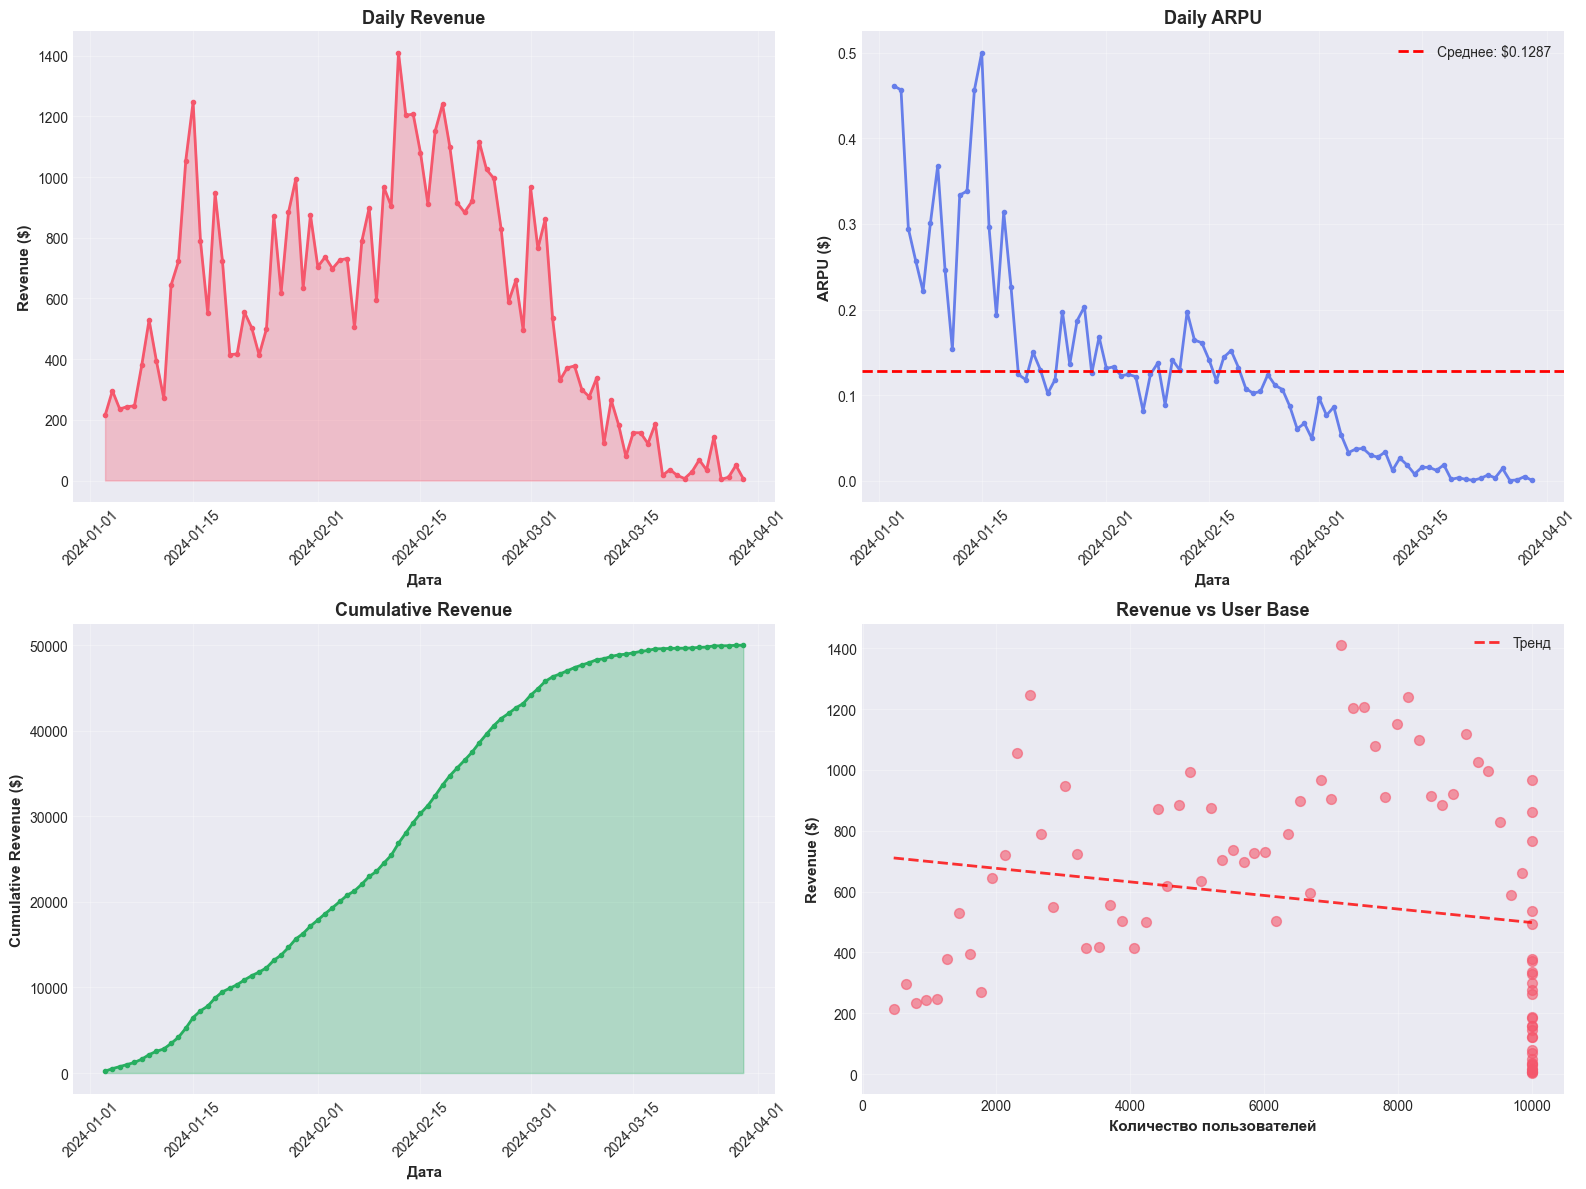

In [4]:
# Визуализация Revenue и ARPU
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# График 1: Daily Revenue
axes[0, 0].plot(daily_revenue_arpu['period'], daily_revenue_arpu['revenue'], 
                linewidth=2, color='#f5576c', marker='o', markersize=3)
axes[0, 0].fill_between(daily_revenue_arpu['period'], daily_revenue_arpu['revenue'], 
                        alpha=0.3, color='#f5576c')
axes[0, 0].set_xlabel('Дата', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Revenue ($)', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Daily Revenue', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# График 2: Daily ARPU
axes[0, 1].plot(daily_revenue_arpu['period'], daily_revenue_arpu['arpu'], 
                linewidth=2, color='#667eea', marker='o', markersize=3)
axes[0, 1].axhline(y=daily_revenue_arpu['arpu'].mean(), color='red', 
                   linestyle='--', linewidth=2,
                   label=f'Среднее: ${daily_revenue_arpu["arpu"].mean():.4f}')
axes[0, 1].set_xlabel('Дата', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('ARPU ($)', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Daily ARPU', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend(fontsize=10)
axes[0, 1].tick_params(axis='x', rotation=45)

# График 3: Cumulative Revenue
daily_revenue_arpu['cumulative_revenue'] = daily_revenue_arpu['revenue'].cumsum()
axes[1, 0].plot(daily_revenue_arpu['period'], daily_revenue_arpu['cumulative_revenue'], 
                linewidth=2, color='#27ae60', marker='o', markersize=3)
axes[1, 0].fill_between(daily_revenue_arpu['period'], daily_revenue_arpu['cumulative_revenue'], 
                        alpha=0.3, color='#27ae60')
axes[1, 0].set_xlabel('Дата', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Cumulative Revenue ($)', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Cumulative Revenue', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=45)

# График 4: Revenue vs Users (scatter)
axes[1, 1].scatter(daily_revenue_arpu['users'], daily_revenue_arpu['revenue'], 
                   alpha=0.6, s=50, color='#f5576c')
axes[1, 1].set_xlabel('Количество пользователей', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Revenue ($)', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Revenue vs User Base', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

# Добавляем линию тренда
z = np.polyfit(daily_revenue_arpu['users'], daily_revenue_arpu['revenue'], 1)
p = np.poly1d(z)
axes[1, 1].plot(daily_revenue_arpu['users'], p(daily_revenue_arpu['users']), 
                "r--", linewidth=2, alpha=0.8, label='Тренд')
axes[1, 1].legend()

plt.tight_layout()
plt.show()


## 2. ARPPU и Conversion Rate

### 📍 Определение ARPPU

**ARPPU (Average Revenue Per Paying User)** — средняя выручка на одного ПЛАТЯЩЕГО пользователя.

### 📍 Определение Conversion Rate

**Conversion Rate (CR)** — процент пользователей, совершивших хотя бы одну покупку.

### 📍 Формулы расчета

$$
\text{ARPPU} = \frac{\text{Revenue}}{\text{Количество платящих пользователей}}
$$

$$
\text{Conversion Rate} = \frac{\text{Платящие пользователи}}{\text{Всего пользователей}} \times 100\%
$$

### 📍 Связь ARPU, ARPPU и CR

$$
\text{ARPU} = \text{ARPPU} \times \text{CR}
$$

Это фундаментальное соотношение показывает, что можно увеличить ARPU двумя путями:
1. Увеличить ARPPU (заставить платящих платить больше)
2. Увеличить CR (конвертировать больше пользователей)

### 📍 Зачем нужны метрики

**ARPPU:**
1. **Показывает качество монетизации среди плательщиков**
   - Насколько глубоко монетизируются те, кто уже платит
   - Не смешивается с конверсией

2. **Индикатор для whale hunting**
   - Высокий ARPPU = игра умеет монетизировать хардкор
   - Важно для high-spender ориентированных игр

3. **Диагностика проблем**
   - Низкий ARPPU при высоком CR = не хватает дорогих офферов
   - Высокий ARPPU при низком CR = слишком агрессивная монетизация

**Conversion Rate:**
1. **Здоровье воронки**
   - Сколько пользователей преодолевают барьер первой покупки
   - Критичный показатель для оценки FTUE и ранней игры

2. **Эффективность монетизации**
   - Чем больше конвертируем, тем лучше LTV
   - Базовая метрика для A/B тестов

3. **Индикатор проблем**
   - Падающий CR = проблемы с воронкой или балансом
   - Низкий CR = слишком высокие цены или недостаток value

### 📍 Что показывает

- **Высокий ARPPU, низкий CR** — whale-ориентированная игра (часто mid-core/hardcore)
- **Средний ARPPU, высокий CR** — широкая монетизация (casual игры)
- **Низкий ARPPU, низкий CR** — проблемы с монетизацией
- **Растущий ARPPU при падающем CR** — whale retention хороший, но теряем мидспендеров

### 📍 Бенчмарки по жанрам

| Жанр | Conversion Rate | ARPPU (месячный) | Стратегия |
|------|----------------|------------------|-----------|
| Hypercasual | 0.5-2% | $5-15 | Ads + IAP |
| Casual | 2-5% | $15-40 | Широкая |
| Match-3 | 3-8% | $20-60 | Широкая |
| Strategy | 5-12% | $40-120 | Средняя |
| RTS | 6-15% | $50-150 | Средняя |
| RPG | 8-20% | $60-180 | Whale-focused |
| Casino | 10-25% | $80-250 | Whale-focused |
| MMO | 15-40% | $100-300 | Subscription + Whales |

### 📍 Timing метрики

**Time to First Purchase:**
- **Hypercasual**: часто нет IAP
- **Casual**: День 3-7
- **Mid-core**: День 2-5
- **Hardcore**: День 1-3

**Conversion by Day:**
- **D1 Conversion**: 20-40% от итогового CR
- **D7 Conversion**: 60-75% от итогового CR
- **D30 Conversion**: 85-95% от итогового CR

### 📍 Как улучшить

**Увеличение CR:**
1. **Снизить барьер первой покупки**
   - Starter pack за $0.99
   - First-time buyer bonus
   - Limited-time первый оффер

2. **Value demonstration**
   - Показать ценность покупок в игре
   - Trial/preview премиум контента
   - Clear benefit communication

3. **Urgency в раннем game**
   - Early walls
   - Limited-time offers день 1-3
   - Strong FTUE hooks

**Увеличение ARPPU:**
1. **Дорогие пакеты**
   - VIP tiers
   - Ultimate bundles $99+
   - Subscription models

2. **Repeat purchase incentives**
   - Лучшая прогрессия
   - Collection mechanics
   - Competitive pressure

3. **Персонализация**
   - High-spender targeted offers
   - Dynamic pricing based on spending
   - VIP exclusive content

### 📍 Расчет на Python


In [5]:
def calculate_arppu_cr(purchases_df, users_df):
    """
    Рассчитывает ARPPU и Conversion Rate
    """
    
    # Плательщики
    paying_users = purchases_df['user_id'].nunique()
    total_users = len(users_df)
    
    # Conversion Rate
    conversion_rate = (paying_users / total_users * 100)
    
    # ARPPU
    total_revenue = purchases_df['amount_usd'].sum()
    arppu = total_revenue / paying_users if paying_users > 0 else 0
    
    # ARPU (для проверки формулы)
    arpu = total_revenue / total_users
    arpu_from_formula = arppu * (conversion_rate / 100)
    
    return {
        'paying_users': paying_users,
        'total_users': total_users,
        'conversion_rate': conversion_rate,
        'arppu': arppu,
        'arpu': arpu,
        'arpu_check': arpu_from_formula
    }

# Рассчитываем метрики
metrics = calculate_arppu_cr(purchases_df, users_df)

print("=" * 80)
print("ARPPU & CONVERSION RATE")
print("=" * 80)
print(f"Всего пользователей: {metrics['total_users']:,}")
print(f"Платящих пользователей: {metrics['paying_users']:,}")
print(f"\nConversion Rate: {metrics['conversion_rate']:.2f}%")
print(f"\nARPPU: ${metrics['arppu']:.2f}")
print(f"ARPU: ${metrics['arpu']:.2f}")
print(f"\n✓ Проверка формулы ARPU = ARPPU × CR:")
print(f"  ARPU (расчет): ${metrics['arpu']:.4f}")
print(f"  ARPU (формула): ${metrics['arpu_check']:.4f}")
print(f"  Разница: ${abs(metrics['arpu'] - metrics['arpu_check']):.6f}")

# Анализ по профилям
profile_analysis = []
for profile in ['minnow', 'dolphin', 'whale']:
    profile_users = users_df[users_df['profile'] == profile]
    profile_purchases = purchases_df[purchases_df['profile'] == profile]
    
    count = len(profile_users)
    revenue = profile_purchases['amount_usd'].sum()
    arppu = revenue / count if count > 0 else 0
    purchases_count = len(profile_purchases)
    purchases_per_user = purchases_count / count if count > 0 else 0
    
    profile_analysis.append({
        'profile': profile,
        'users': count,
        'revenue': revenue,
        'arppu': arppu,
        'purchases': purchases_count,
        'purchases_per_user': purchases_per_user
    })

profile_df = pd.DataFrame(profile_analysis)

print(f"\n" + "=" * 80)
print("MONETIZATION BY PROFILE")
print("=" * 80)
print(profile_df.to_string(index=False))

# Вклад в revenue по профилям
print(f"\n% вклада в общий revenue:")
for _, row in profile_df.iterrows():
    pct = row['revenue'] / total_revenue * 100
    print(f"  {row['profile']}: {pct:.1f}%")

# Time to first purchase
first_purchases = purchases_df.groupby('user_id').agg({
    'days_since_install': 'min',
    'profile': 'first'
}).reset_index()

print(f"\n" + "=" * 80)
print("TIME TO FIRST PURCHASE")
print("=" * 80)
print(f"Медиана: {first_purchases['days_since_install'].median():.1f} дней")
print(f"Среднее: {first_purchases['days_since_install'].mean():.1f} дней")
print(f"\nПо профилям:")
for profile in ['minnow', 'dolphin', 'whale']:
    ttfp = first_purchases[first_purchases['profile'] == profile]['days_since_install'].median()
    print(f"  {profile}: {ttfp:.1f} дней")


ARPPU & CONVERSION RATE
Всего пользователей: 10,000
Платящих пользователей: 503

Conversion Rate: 5.03%

ARPPU: $99.37
ARPU: $5.00

✓ Проверка формулы ARPU = ARPPU × CR:
  ARPU (расчет): $4.9983
  ARPU (формула): $4.9983
  Разница: $0.000000

MONETIZATION BY PROFILE
profile  users  revenue      arppu  purchases  purchases_per_user
 minnow    297  2820.29   9.495926        762            2.565657
dolphin    151 13993.97  92.675298       1784           11.814570
  whale     55 33168.73 603.067818       3104           56.436364

% вклада в общий revenue:
  minnow: 5.6%
  dolphin: 28.0%
  whale: 66.4%

TIME TO FIRST PURCHASE
Медиана: 5.0 дней
Среднее: 5.9 дней

По профилям:
  minnow: 8.0 дней
  dolphin: 4.0 дней
  whale: 1.0 дней


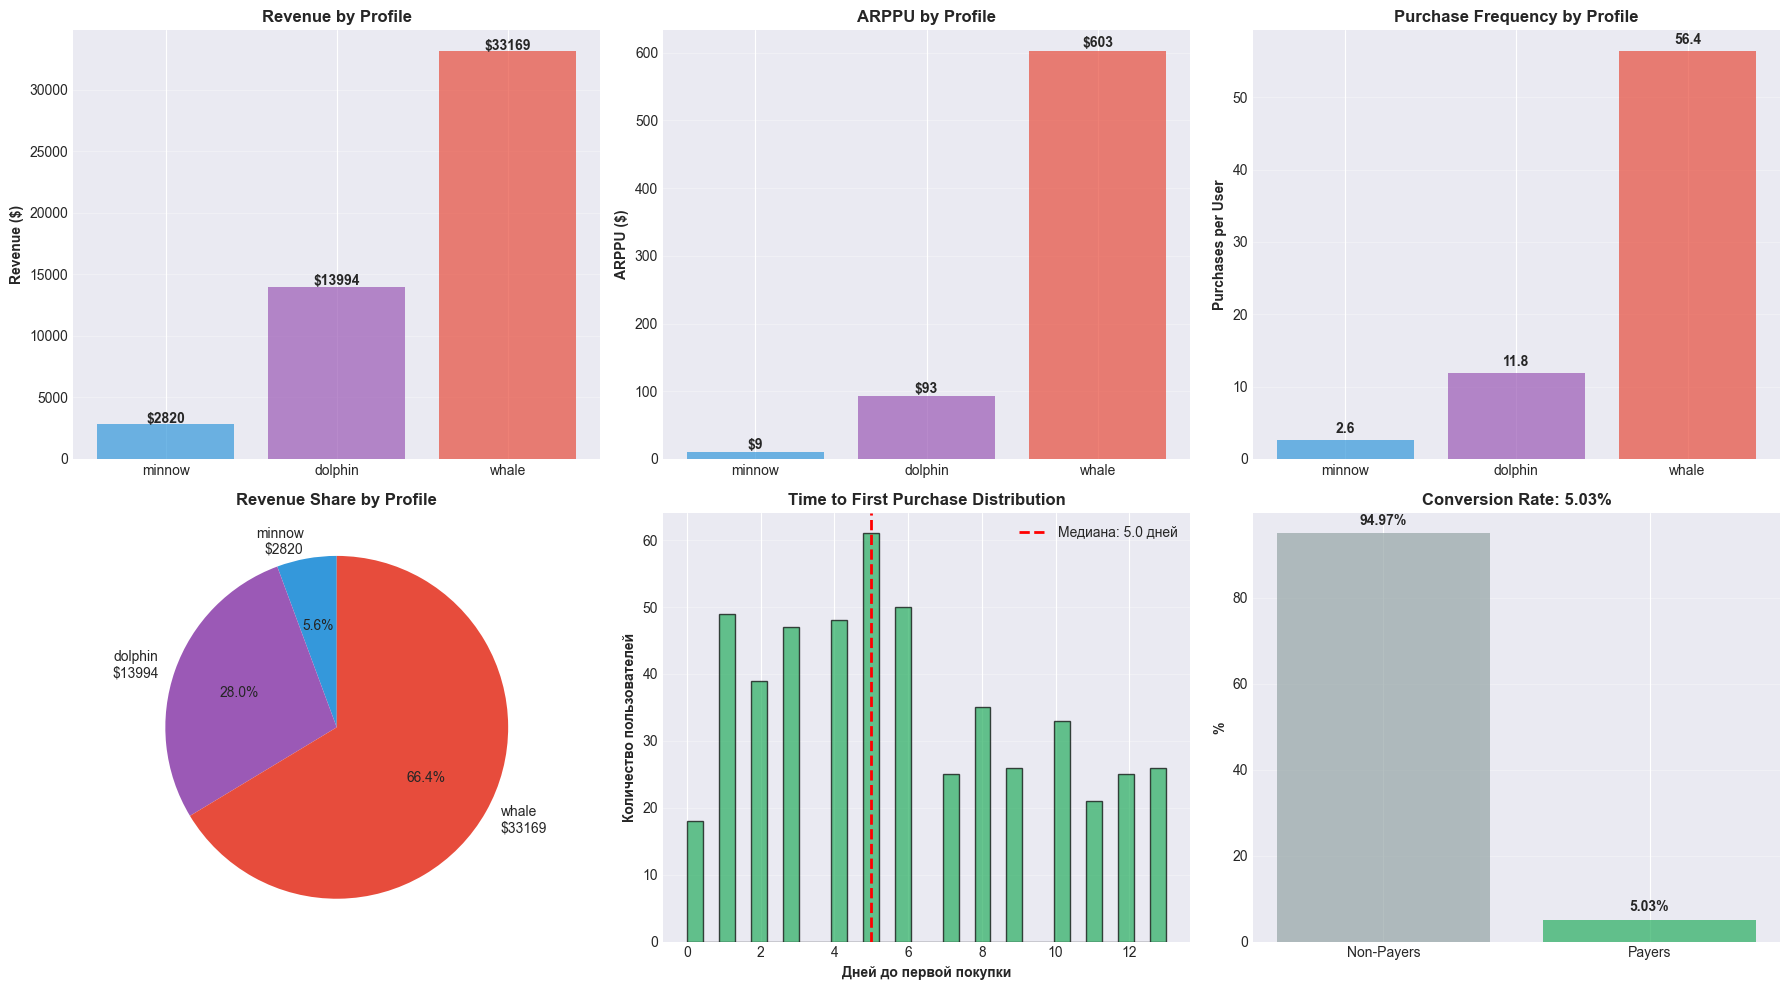

In [6]:
# Визуализация ARPPU, CR и профилей
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# График 1: Revenue distribution by profile
axes[0, 0].bar(profile_df['profile'], profile_df['revenue'], 
               color=['#3498db', '#9b59b6', '#e74c3c'], alpha=0.7)
axes[0, 0].set_ylabel('Revenue ($)', fontsize=10, fontweight='bold')
axes[0, 0].set_title('Revenue by Profile', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='y')
for i, row in profile_df.iterrows():
    axes[0, 0].text(i, row['revenue'] + 100, f"${row['revenue']:.0f}", 
                    ha='center', fontweight='bold')

# График 2: ARPPU by profile
axes[0, 1].bar(profile_df['profile'], profile_df['arppu'], 
               color=['#3498db', '#9b59b6', '#e74c3c'], alpha=0.7)
axes[0, 1].set_ylabel('ARPPU ($)', fontsize=10, fontweight='bold')
axes[0, 1].set_title('ARPPU by Profile', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')
for i, row in profile_df.iterrows():
    axes[0, 1].text(i, row['arppu'] + 5, f"${row['arppu']:.0f}", 
                    ha='center', fontweight='bold')

# График 3: Purchases per user by profile
axes[0, 2].bar(profile_df['profile'], profile_df['purchases_per_user'], 
               color=['#3498db', '#9b59b6', '#e74c3c'], alpha=0.7)
axes[0, 2].set_ylabel('Purchases per User', fontsize=10, fontweight='bold')
axes[0, 2].set_title('Purchase Frequency by Profile', fontsize=12, fontweight='bold')
axes[0, 2].grid(True, alpha=0.3, axis='y')
for i, row in profile_df.iterrows():
    axes[0, 2].text(i, row['purchases_per_user'] + 1, 
                    f"{row['purchases_per_user']:.1f}", 
                    ha='center', fontweight='bold')

# График 4: Revenue pie chart
revenue_data = profile_df['revenue'].values
labels = [f"{p}\n${r:.0f}" for p, r in zip(profile_df['profile'], profile_df['revenue'])]
colors_pie = ['#3498db', '#9b59b6', '#e74c3c']
axes[1, 0].pie(revenue_data, labels=labels, colors=colors_pie, autopct='%1.1f%%',
               startangle=90)
axes[1, 0].set_title('Revenue Share by Profile', fontsize=12, fontweight='bold')

# График 5: Distribution of time to first purchase
axes[1, 1].hist(first_purchases['days_since_install'], bins=30, 
                color='#27ae60', alpha=0.7, edgecolor='black')
axes[1, 1].axvline(x=first_purchases['days_since_install'].median(), 
                   color='red', linestyle='--', linewidth=2,
                   label=f'Медиана: {first_purchases["days_since_install"].median():.1f} дней')
axes[1, 1].set_xlabel('Дней до первой покупки', fontsize=10, fontweight='bold')
axes[1, 1].set_ylabel('Количество пользователей', fontsize=10, fontweight='bold')
axes[1, 1].set_title('Time to First Purchase Distribution', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].legend()

# График 6: Conversion Rate visualization
cr_data = {
    'Non-Payers': 100 - metrics['conversion_rate'],
    'Payers': metrics['conversion_rate']
}
axes[1, 2].bar(cr_data.keys(), cr_data.values(), 
               color=['#95a5a6', '#27ae60'], alpha=0.7)
axes[1, 2].set_ylabel('%', fontsize=10, fontweight='bold')
axes[1, 2].set_title(f'Conversion Rate: {metrics["conversion_rate"]:.2f}%', 
                    fontsize=12, fontweight='bold')
axes[1, 2].grid(True, alpha=0.3, axis='y')
for i, (key, val) in enumerate(cr_data.items()):
    axes[1, 2].text(i, val + 2, f'{val:.2f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


## 3. Purchase Frequency, ATV и Whale Metrics

### 📍 Определение Purchase Frequency

**Purchase Frequency** — среднее количество покупок на одного платящего пользователя за период.

$$
\text{Purchase Frequency} = \frac{\text{Количество покупок}}{\text{Количество платящих пользователей}}
$$

### 📍 Определение ATV

**ATV (Average Transaction Value)** — средний размер одной покупки.

$$
\text{ATV} = \frac{\text{Revenue}}{\text{Количество покупок}}
$$

### 📍 Связь ARPPU, ATV и Purchase Frequency

$$
\text{ARPPU} = \text{ATV} \times \text{Purchase Frequency}
$$

Это показывает, что ARPPU можно увеличить:
1. Увеличив размер каждой покупки (ATV)
2. Увеличив частоту покупок (Purchase Frequency)

### 📍 Whale Metrics

**Whale** — высокооплачивающий пользователь (обычно top 1-5% по revenue).

Ключевые метрики:
- **Whale Revenue %** — процент revenue от китов
- **Whale Count** — количество китов
- **Whale ARPPU** — средний чек кита

**Классификация:**
- **Minnow** — минимальные траты ($1-10)
- **Dolphin** — средние траты ($10-100)
- **Whale** — высокие траты ($100+)
- **Mega Whale** — очень высокие траты ($1000+)

### 📍 Бенчмарки

| Метрика | Casual | Mid-core | Hardcore |
|---------|--------|----------|----------|
| Purchase Frequency | 2-5 | 5-15 | 15-40 |
| ATV | $3-8 | $8-20 | $15-40 |
| Whale Revenue % | 30-50% | 50-70% | 70-90% |
| Top 1% Revenue % | 15-25% | 25-40% | 40-60% |

### 📍 Расчет на Python


In [14]:
# Purchase Frequency и ATV
total_purchases = len(purchases_df)
paying_users = purchases_df['user_id'].nunique()
total_revenue = purchases_df['amount_usd'].sum()

purchase_frequency = total_purchases / paying_users
atv = total_revenue / total_purchases
arppu_check = atv * purchase_frequency

print("=" * 80)
print("PURCHASE FREQUENCY & ATV")
print("=" * 80)
print(f"Всего покупок: {total_purchases:,}")
print(f"Платящих пользователей: {paying_users:,}")
print(f"\nPurchase Frequency: {purchase_frequency:.2f} покупок/плательщика")
print(f"ATV (Average Transaction Value): ${atv:.2f}")
print(f"\n✓ Проверка формулы ARPPU = ATV × Purchase Frequency:")
print(f"  ARPPU (расчет): ${metrics['arppu']:.2f}")
print(f"  ARPPU (формула): ${arppu_check:.2f}")

# Whale Analysis
user_revenue = purchases_df.groupby('user_id')['amount_usd'].sum().reset_index()
user_revenue.columns = ['user_id', 'total_spent']
user_revenue = user_revenue.sort_values('total_spent', ascending=False).reset_index(drop=True)

# Определяем китов (top 5% по тратам)
whale_threshold = user_revenue['total_spent'].quantile(0.95)
whales = user_revenue[user_revenue['total_spent'] >= whale_threshold]

# Определяем mega whales (top 1%)
mega_whale_threshold = user_revenue['total_spent'].quantile(0.99)
mega_whales = user_revenue[user_revenue['total_spent'] >= mega_whale_threshold]

# Статистика по китам
whale_revenue = whales['total_spent'].sum()
whale_revenue_pct = (whale_revenue / total_revenue * 100)

mega_whale_revenue = mega_whales['total_spent'].sum()
mega_whale_revenue_pct = (mega_whale_revenue / total_revenue * 100)

print(f"\n" + "=" * 80)
print("WHALE METRICS")
print("=" * 80)
print(f"Whale threshold (top 5%): ${whale_threshold:.2f}")
print(f"Mega Whale threshold (top 1%): ${mega_whale_threshold:.2f}")
print(f"\nWhales (top 5%):")
print(f"  Количество: {len(whales)} ({len(whales)/paying_users*100:.1f}% плательщиков)")
print(f"  Revenue: ${whale_revenue:.2f} ({whale_revenue_pct:.1f}% от total)")
print(f"  Средние траты: ${whales['total_spent'].mean():.2f}")

print(f"\nMega Whales (top 1%):")
print(f"  Количество: {len(mega_whales)} ({len(mega_whales)/paying_users*100:.1f}% плательщиков)")
print(f"  Revenue: ${mega_whale_revenue:.2f} ({mega_whale_revenue_pct:.1f}% от total)")
print(f"  Средние траты: ${mega_whales['total_spent'].mean():.2f}")

# Топ-10 spenders
print(f"\nТоп-10 плательщиков:")
top10 = user_revenue.head(10)
print(top10.to_string(index=False))

# Revenue distribution анализ (Парето) - ИСПРАВЛЕНО
# После reset_index индексы теперь соответствуют позиции в отсортированном списке
user_revenue['cumulative_revenue'] = user_revenue['total_spent'].cumsum()
user_revenue['cumulative_pct'] = user_revenue['cumulative_revenue'] / total_revenue * 100
user_revenue['user_pct'] = (user_revenue.index + 1) / len(user_revenue) * 100

# 80/20 rule check
revenue_80_pct = total_revenue * 0.8
users_for_80_revenue = user_revenue[user_revenue['cumulative_revenue'] <= revenue_80_pct].shape[0]
pct_users_for_80_revenue = (users_for_80_revenue / len(user_revenue) * 100)

print(f"\n80/20 анализ (Pareto Principle):")
print(f"  {pct_users_for_80_revenue:.1f}% плательщиков генерируют 80% revenue")
print(f"  (Классический 80/20: 20% пользователей = 80% revenue)")


PURCHASE FREQUENCY & ATV
Всего покупок: 5,650
Платящих пользователей: 503

Purchase Frequency: 11.23 покупок/плательщика
ATV (Average Transaction Value): $8.85

✓ Проверка формулы ARPPU = ATV × Purchase Frequency:
  ARPPU (расчет): $99.37
  ARPPU (формула): $99.37

WHALE METRICS
Whale threshold (top 5%): $665.42
Mega Whale threshold (top 1%): $949.50

Whales (top 5%):
  Количество: 26 (5.2% плательщиков)
  Revenue: $21818.83 (43.7% от total)
  Средние траты: $839.19

Mega Whales (top 1%):
  Количество: 6 (1.2% плательщиков)
  Revenue: $6039.29 (12.1% от total)
  Средние траты: $1006.55

Топ-10 плательщиков:
   user_id  total_spent
user_04700      1062.89
user_09289      1023.39
user_02282      1009.45
user_00400      1002.11
user_07049       991.89
user_08426       949.56
user_03422       946.48
user_06879       900.15
user_07542       873.08
user_02541       871.46

80/20 анализ (Pareto Principle):
  19.3% плательщиков генерируют 80% revenue
  (Классический 80/20: 20% пользователей = 

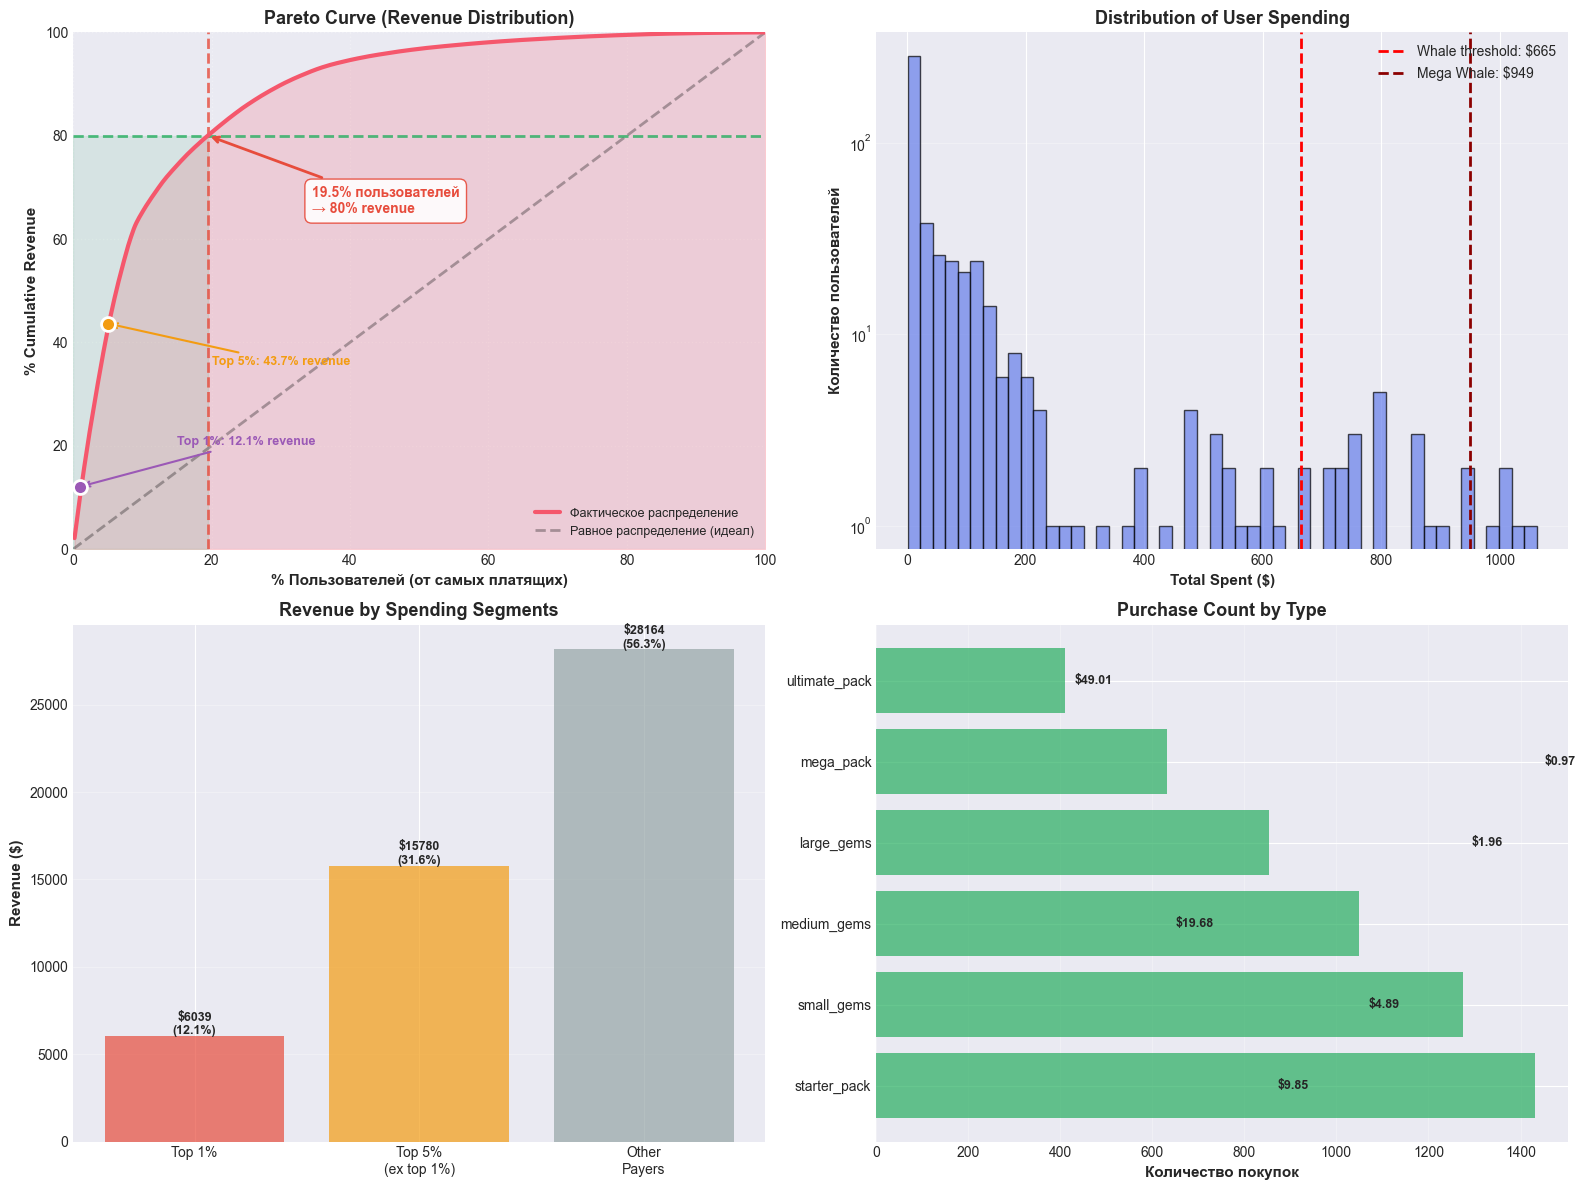

In [15]:
# Визуализация Whale Metrics и Revenue Distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# График 1: Revenue Distribution (Парето кривая) - УЛУЧШЕННАЯ ВЕРСИЯ
# ВАЖНО: Сортируем данные по user_pct для правильного построения кривой
pareto_data = user_revenue.sort_values('user_pct').reset_index(drop=True)

# Находим точку, где достигается 80% revenue
revenue_80_idx = pareto_data[pareto_data['cumulative_pct'] >= 80].index[0]
users_pct_for_80 = pareto_data.loc[revenue_80_idx, 'user_pct']

# Основная кривая Парето
axes[0, 0].plot(pareto_data['user_pct'], pareto_data['cumulative_pct'], 
                linewidth=3, color='#f5576c', label='Фактическое распределение', zorder=3)

# Заполнение области под кривой
axes[0, 0].fill_between(pareto_data['user_pct'], pareto_data['cumulative_pct'], 
                        alpha=0.2, color='#f5576c')

# Линия идеального распределения
axes[0, 0].plot([0, 100], [0, 100], 'k--', linewidth=2, alpha=0.3, 
                label='Равное распределение (идеал)')

# 80/20 линии
axes[0, 0].axhline(y=80, color='#27ae60', linestyle='--', linewidth=2, alpha=0.8)
axes[0, 0].axvline(x=users_pct_for_80, color='#e74c3c', linestyle='--', linewidth=2, alpha=0.8)

# Заполнение области 80/20
axes[0, 0].fill_between([0, users_pct_for_80], [0, 0], [80, 80], 
                        alpha=0.1, color='#27ae60')

# Аннотации
axes[0, 0].annotate(f'{users_pct_for_80:.1f}% пользователей\n→ 80% revenue', 
                    xy=(users_pct_for_80, 80), xytext=(users_pct_for_80 + 15, 65),
                    arrowprops=dict(arrowstyle='->', color='#e74c3c', lw=2),
                    fontsize=10, fontweight='bold', color='#e74c3c',
                    bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='#e74c3c', alpha=0.9))

# Точка Top 1%
top1_idx = int(len(pareto_data) * 0.01)
top1_revenue_pct = pareto_data.iloc[top1_idx]['cumulative_pct']
axes[0, 0].scatter([1], [top1_revenue_pct], s=100, color='#9b59b6', zorder=5, 
                   edgecolor='white', linewidth=2)
axes[0, 0].annotate(f'Top 1%: {top1_revenue_pct:.1f}% revenue', 
                    xy=(1, top1_revenue_pct), xytext=(15, top1_revenue_pct + 8),
                    arrowprops=dict(arrowstyle='->', color='#9b59b6', lw=1.5),
                    fontsize=9, fontweight='bold', color='#9b59b6')

# Точка Top 5%
top5_idx = int(len(pareto_data) * 0.05)
top5_revenue_pct = pareto_data.iloc[top5_idx]['cumulative_pct']
axes[0, 0].scatter([5], [top5_revenue_pct], s=100, color='#f39c12', zorder=5,
                   edgecolor='white', linewidth=2)
axes[0, 0].annotate(f'Top 5%: {top5_revenue_pct:.1f}% revenue', 
                    xy=(5, top5_revenue_pct), xytext=(20, top5_revenue_pct - 8),
                    arrowprops=dict(arrowstyle='->', color='#f39c12', lw=1.5),
                    fontsize=9, fontweight='bold', color='#f39c12')

axes[0, 0].set_xlabel('% Пользователей (от самых платящих)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('% Cumulative Revenue', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Pareto Curve (Revenue Distribution)', fontsize=13, fontweight='bold')
axes[0, 0].set_xlim(0, 100)
axes[0, 0].set_ylim(0, 100)
axes[0, 0].grid(True, alpha=0.3, linestyle=':', linewidth=1)
axes[0, 0].legend(loc='lower right', fontsize=9)

# График 2: Distribution of spending per user (log scale)
axes[0, 1].hist(user_revenue['total_spent'], bins=50, color='#667eea', 
                alpha=0.7, edgecolor='black')
axes[0, 1].axvline(x=whale_threshold, color='red', linestyle='--', linewidth=2,
                   label=f'Whale threshold: ${whale_threshold:.0f}')
axes[0, 1].axvline(x=mega_whale_threshold, color='darkred', linestyle='--', linewidth=2,
                   label=f'Mega Whale: ${mega_whale_threshold:.0f}')
axes[0, 1].set_xlabel('Total Spent ($)', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Количество пользователей', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Distribution of User Spending', fontsize=13, fontweight='bold')
axes[0, 1].set_yscale('log')
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].legend()

# График 3: Revenue contribution by segments
segments = {
    'Top 1%': mega_whale_revenue,
    'Top 5%\n(ex top 1%)': whale_revenue - mega_whale_revenue,
    'Other\nPayers': total_revenue - whale_revenue
}
colors_seg = ['#e74c3c', '#f39c12', '#95a5a6']
axes[1, 0].bar(segments.keys(), segments.values(), color=colors_seg, alpha=0.7)
axes[1, 0].set_ylabel('Revenue ($)', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Revenue by Spending Segments', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')
for i, (key, val) in enumerate(segments.items()):
    pct = val / total_revenue * 100
    axes[1, 0].text(i, val + 100, f'${val:.0f}\n({pct:.1f}%)', 
                    ha='center', fontweight='bold', fontsize=9)

# График 4: Distribution of purchases by price point
price_distribution = purchases_df.groupby('purchase_type').agg({
    'amount_usd': ['mean', 'count']
}).reset_index()
price_distribution.columns = ['purchase_type', 'avg_price', 'count']
price_distribution = price_distribution.sort_values('avg_price')

axes[1, 1].barh(price_distribution['purchase_type'], price_distribution['count'], 
                color='#27ae60', alpha=0.7)
axes[1, 1].set_xlabel('Количество покупок', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Purchase Count by Type', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='x')
for i, row in price_distribution.iterrows():
    axes[1, 1].text(row['count'] + 20, i, f"${row['avg_price']:.2f}", 
                    va='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()


<div style="padding: 2em; background: linear-gradient(135deg, #f093fb 0%, #f5576c 100%); border-radius: 12px; margin: 2em 0; color: white;">
  <h2 style="margin: 0 0 1em 0; font-size: 2em; font-weight: 600;">📍 Резюме и Best Practices</h2>
</div>

## Ключевые выводы

### 📍 Фундаментальные формулы монетизации

**1. Базовое соотношение:**
$$
\text{ARPU} = \text{ARPPU} \times \text{CR}
$$

**2. Декомпозиция ARPPU:**
$$
\text{ARPPU} = \text{ATV} \times \text{Purchase Frequency}
$$

**3. Полная формула:**
$$
\text{ARPU} = \text{ATV} \times \text{Purchase Frequency} \times \text{CR}
$$

**Это значит, что Revenue можно улучшить через:**
1. ↑ ATV (больше дорогих пакетов)
2. ↑ Purchase Frequency (чаще покупают)
3. ↑ CR (больше конвертируем)

### 📍 Типичные соотношения метрик

**Casual игры:**
```
CR: 2-5%
ARPPU: $20-60
Purchase Frequency: 2-5
ATV: $5-12
Whale Revenue %: 30-50%
```

**Mid-core:**
```
CR: 5-12%
ARPPU: $50-150
Purchase Frequency: 5-15
ATV: $10-25
Whale Revenue %: 50-70%
```

**Hardcore:**
```
CR: 8-20%
ARPPU: $80-250
Purchase Frequency: 15-40
ATV: $15-40
Whale Revenue %: 70-90%
```

### 📍 Красные флаги (Red Flags)

1. **Падающий ARPU**
   - Проблема с монетизацией или качеством трафика
   - Нужно срочно анализировать причины

2. **Высокий CR, низкий ARPPU**
   - Нет достаточно дорогих пакетов
   - Недостаток контента для повторных покупок

3. **Низкий CR, высокий ARPPU**
   - Слишком агрессивная монетизация
   - Отпугиваем casual спендеров
   - Риск оттока

4. **Падающий CR при росте users**
   - Ухудшение quality of traffic
   - Проблемы с onboarding

5. **Whale Revenue > 80%**
   - Очень высокий риск
   - Потеря нескольких китов = катастрофа
   - Нужно работать над mid-spenders

6. **Purchase Frequency < 1.5**
   - Люди покупают один раз и уходят
   - Проблема с retention или value proposition

### 📍 Стратегии монетизации по жанрам

**Hypercasual:**
- **Основное**: Ads + minimal IAP
- **CR**: очень низкий (0.5-2%)
- **Фокус**: CPM, ad load optimization

**Casual/Match-3:**
- **Стратегия**: Широкая монетизация
- **Цель**: максимизировать CR
- **Тактика**: Low-priced bundles, frequent offers

**Strategy/RTS:**
- **Стратегия**: Balanced (mid-spenders + whales)
- **Цель**: оптимальный ARPPU × CR
- **Тактика**: Tiered offers, VIP systems

**RPG/MMO:**
- **Стратегия**: Whale-focused
- **Цель**: максимизировать ARPPU
- **Тактика**: High-priced items, gacha, power progression

### 📍 Как улучшить монетизацию

#### 📍 Увеличение CR (Конверсии)

**Первая покупка:**
1. **Starter Pack** за $0.99-1.99
   - x10 value
   - Limited time (24 часа)
   - One-time only

2. **Early walls**
   - Energy systems
   - Difficulty spikes на уровне 10-15
   - Clear value proposition

3. **First-time buyer bonus**
   - Дополнительная валюта
   - Exclusive items
   - Instant gratification

**Повторные покупки:**
1. **Subscription модели**
   - Battle Pass
   - Monthly card (лучший ROI)
   - VIP membership

2. **FOMO механики**
   - Limited-time events
   - Seasonal content
   - Exclusive items

#### 📍 Увеличение ARPPU

**ATV (размер чека):**
1. **Tiered pricing**
   - $0.99, $4.99, $9.99, $19.99, $49.99, $99.99
   - Каждый tier имеет clear value prop

2. **Bundle optimization**
   - Больше value в дорогих пакетах
   - "Best Value" тэги
   - Anchor pricing

3. **Dynamic pricing**
   - Персонализация на основе поведения
   - A/B тесты цен
   - Regional pricing

**Purchase Frequency:**
1. **Progression walls**
   - Regular choke points
   - Clear benefit от покупок
   - Multiple ways to spend

2. **Currency sinks**
   - Upgrades
   - Collection mechanics
   - Competitive features

3. **Retention features**
   - Daily deals
   - Login bonuses (требующие покупок)
   - Long-term goals

#### 📍 Whale Management

**Привлечение:**
1. **High-tier content**
   - VIP levels
   - Exclusive items $50+
   - Status symbols

2. **Competitive features**
   - Leaderboards
   - Guild wars
   - PvP seasons

**Удержание:**
1. **Personal attention**
   - VIP support
   - Direct communication
   - Exclusive events

2. **Continuous value**
   - Regular new content
   - Power progression
   - Collection completeness

### 📍 A/B тестирование монетизации

**Что тестировать:**

**Price points:**
- $0.99 vs $1.99 для starter pack
- $4.99 vs $5.99 vs $6.99 для mid-tier
- Bundle composition

**Timing:**
- День первого оффера (D1 vs D3)
- Частота офферов
- Duration of sales

**Messaging:**
- Value communication
- Urgency messaging
- Visual design

**Ключевые метрики:**
- **Primary**: ARPU, CR
- **Secondary**: ARPPU, Purchase Frequency
- **Guardrail**: Retention, NPS

### 📍 Взаимосвязь с другими метриками

**Monetization ↔ Retention:**
- Aggressive monetization может снизить retention
- Хороший retention увеличивает LTV
- Баланс критичен

**Monetization ↔ Engagement:**
- Высокий playtime → больше touchpoints → больше продаж
- Но слишком много ads/offers вредят engagement

**Monetization ↔ UA:**
- Высокий LTV → можно платить больше за UA
- Quality of traffic влияет на CR и ARPPU

### 📍 Региональные особенности

**Tier 1 (US, UK, CA, AU):**
- Высокий ARPU, высокие ожидания
- Фокус: premium experience

**Tier 2 (EU, JP, KR):**
- Средний-высокий ARPU
- Важна локализация

**Tier 3 (LATAM, SEA, RU, CN):**
- Низкий ARPU, но большие объемы
- Фокус: volume, ads, low-price offers

---

## Финальный Summary Dashboard


In [ ]:
# Финальный Monetization Dashboard
print("\n" + "=" * 100)
print(" " * 35 + "MONETIZATION METRICS SUMMARY")
print("=" * 100)

print("\n📍 ОСНОВНЫЕ МЕТРИКИ:")
print("-" * 100)
print(f"{'Метрика':<40} {'Значение':<30} {'Статус':<30}")
print("-" * 100)

# Revenue
print(f"{'Total Revenue':<40} ${total_revenue:,.2f}")

# ARPU
arpu_status = "✅ Хорошо" if overall_arpu > 5 else "⚠️ Средне" if overall_arpu > 2 else "❌ Низко"
print(f"{'ARPU':<40} ${overall_arpu:.2f} {'':<23} {arpu_status}")

# ARPPU
arppu_status = "✅ Хорошо" if metrics['arppu'] > 100 else "⚠️ Средне" if metrics['arppu'] > 40 else "❌ Низко"
arppu_val = metrics['arppu']
print(f"{'ARPPU':<40} ${arppu_val:.2f} {'':<23} {arppu_status}")

# Conversion Rate
cr_status = "✅ Хорошо" if metrics['conversion_rate'] > 8 else "⚠️ Средне" if metrics['conversion_rate'] > 3 else "❌ Низко"
print(f"{'Conversion Rate':<40} {metrics['conversion_rate']:.2f}% {'':<23} {cr_status}")

# ATV
atv_status = "✅ Хорошо" if atv > 15 else "⚠️ Средне" if atv > 8 else "❌ Низко"
print(f"{'ATV (Avg Transaction Value)':<40} ${atv:.2f} {'':<23} {atv_status}")

# Purchase Frequency
pf_status = "✅ Хорошо" if purchase_frequency > 10 else "⚠️ Средне" if purchase_frequency > 3 else "❌ Низко"
print(f"{'Purchase Frequency':<40} {purchase_frequency:.2f} покупок/плательщик {'':<7} {pf_status}")

print("-" * 100)

print("\n📍 WHALE METRICS:")
print("-" * 100)
print(f"Whale threshold (top 5%): ${whale_threshold:.2f}")
print(f"Whale Revenue: ${whale_revenue:.2f} ({whale_revenue_pct:.1f}% от total)")
print(f"\nMega Whale threshold (top 1%): ${mega_whale_threshold:.2f}")
print(f"Mega Whale Revenue: ${mega_whale_revenue:.2f} ({mega_whale_revenue_pct:.1f}% от total)")
print(f"\nPareto Analysis: {pct_users_for_80_revenue:.1f}% плательщиков → 80% revenue")

print("-" * 100)

print("\n📍 ПРОФИЛИ ПОЛЬЗОВАТЕЛЕЙ:")
print("-" * 100)
print(f"{'Профиль':<15} {'Пользователи':<15} {'Revenue':<20} {'ARPPU':<15} {'% Revenue':<15}")
print("-" * 100)
for _, row in profile_df.iterrows():
    pct_rev = row['revenue'] / total_revenue * 100
    print(f"{row['profile']:<15} {row['users']:<15} ${row['revenue']:<19,.0f} ${row['arppu']:<14,.0f} {pct_rev:<14.1f}%")

print("-" * 100)

print("\n📍 ФОРМУЛЫ И ПРОВЕРКИ:")
print("-" * 100)
print(f"✓ ARPU = ARPPU × CR:")
print(f"  ${metrics['arpu']:.4f} = ${metrics['arppu']:.2f} × {metrics['conversion_rate']:.2f}%")
print(f"  Проверка: ${metrics['arpu_check']:.4f}")
print(f"\n✓ ARPPU = ATV × Purchase Frequency:")
print(f"  ${metrics['arppu']:.2f} = ${atv:.2f} × {purchase_frequency:.2f}")
print(f"  Проверка: ${arppu_check:.2f}")

print("\n" + "=" * 100)
print("✅ Анализ завершен!")
print("=" * 100)


SyntaxError: f-string: unmatched '[' (3049814862.py, line 20)

In [ ]:
# Comprehensive Monetization Dashboard - все метрики на одном экране
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# График 1: Revenue over time
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(daily_revenue_arpu['period'], daily_revenue_arpu['revenue'], 
         linewidth=2, color='#f5576c', marker='o', markersize=3)
ax1.fill_between(daily_revenue_arpu['period'], daily_revenue_arpu['revenue'], alpha=0.3, color='#f5576c')
ax1.set_title('Daily Revenue', fontsize=12, fontweight='bold')
ax1.set_ylabel('$')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45, labelsize=8)

# График 2: ARPU & ARPPU
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(daily_revenue_arpu['period'], daily_revenue_arpu['arpu'], 
         label='ARPU', linewidth=2, marker='o', markersize=3)
ax2.set_title('ARPU Trend', fontsize=12, fontweight='bold')
ax2.set_ylabel('$')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45, labelsize=8)

# График 3: Conversion Rate
ax3 = fig.add_subplot(gs[0, 2])
cr_bar = ax3.bar(['Non-Payers', 'Payers'], 
                  [100 - metrics['conversion_rate'], metrics['conversion_rate']],
                  color=['#95a5a6', '#27ae60'], alpha=0.7)
ax3.set_title(f'Conversion Rate: {metrics["conversion_rate"]:.2f}%', 
              fontsize=12, fontweight='bold')
ax3.set_ylabel('%')
ax3.grid(True, alpha=0.3, axis='y')

# График 4: Revenue by Profile
ax4 = fig.add_subplot(gs[1, 0])
ax4.bar(profile_df['profile'], profile_df['revenue'], 
        color=['#3498db', '#9b59b6', '#e74c3c'], alpha=0.7)
ax4.set_title('Revenue by Profile', fontsize=12, fontweight='bold')
ax4.set_ylabel('$')
ax4.grid(True, alpha=0.3, axis='y')
ax4.tick_params(axis='x', rotation=45)

# График 5: Pareto Curve - УЛУЧШЕННАЯ ВЕРСИЯ
ax5 = fig.add_subplot(gs[1, 1])

# ВАЖНО: Сортируем данные по user_pct для правильного построения
pareto_data_dash = user_revenue.sort_values('user_pct').reset_index(drop=True)

# Находим точку 80% revenue
revenue_80_idx = pareto_data_dash[pareto_data_dash['cumulative_pct'] >= 80].index[0]
users_pct_for_80 = pareto_data_dash.loc[revenue_80_idx, 'user_pct']

# Основная кривая
ax5.plot(pareto_data_dash['user_pct'], pareto_data_dash['cumulative_pct'], 
         linewidth=3, color='#f5576c', zorder=3)
ax5.fill_between(pareto_data_dash['user_pct'], pareto_data_dash['cumulative_pct'], 
                 alpha=0.2, color='#f5576c')

# Линия равного распределения
ax5.plot([0, 100], [0, 100], 'k--', linewidth=1.5, alpha=0.3)

# 80% линии
ax5.axhline(y=80, color='#27ae60', linestyle='--', linewidth=2, alpha=0.8)
ax5.axvline(x=users_pct_for_80, color='#e74c3c', linestyle='--', linewidth=2, alpha=0.8)
ax5.fill_between([0, users_pct_for_80], [0, 0], [80, 80], alpha=0.1, color='#27ae60')

# Ключевые точки
top1_idx = int(len(pareto_data_dash) * 0.01)
top1_revenue = pareto_data_dash.iloc[top1_idx]['cumulative_pct']
ax5.scatter([1], [top1_revenue], s=80, color='#9b59b6', zorder=5, edgecolor='white', linewidth=1.5)

top5_idx = int(len(pareto_data_dash) * 0.05)
top5_revenue = pareto_data_dash.iloc[top5_idx]['cumulative_pct']
ax5.scatter([5], [top5_revenue], s=80, color='#f39c12', zorder=5, edgecolor='white', linewidth=1.5)

# Аннотация
ax5.text(users_pct_for_80 + 5, 75, f'{users_pct_for_80:.0f}% → 80%', 
         fontsize=9, fontweight='bold', color='#e74c3c')

ax5.set_title('Pareto Distribution', fontsize=12, fontweight='bold')
ax5.set_xlabel('% Users', fontsize=10)
ax5.set_ylabel('% Revenue', fontsize=10)
ax5.set_xlim(0, 100)
ax5.set_ylim(0, 100)
ax5.grid(True, alpha=0.3, linestyle=':')

# График 6: Whale Revenue Share
ax6 = fig.add_subplot(gs[1, 2])
whale_segments = ['Top 1%', 'Top 5%\n(ex 1%)', 'Others']
whale_rev = [mega_whale_revenue, whale_revenue - mega_whale_revenue, 
             total_revenue - whale_revenue]
ax6.pie(whale_rev, labels=[f'{s}\n${r:.0f}' for s, r in zip(whale_segments, whale_rev)],
        colors=['#e74c3c', '#f39c12', '#95a5a6'], autopct='%1.1f%%', startangle=90)
ax6.set_title('Revenue by Segment', fontsize=12, fontweight='bold')

# График 7: Purchase Type Distribution
ax7 = fig.add_subplot(gs[2, 0])
price_dist = price_distribution.sort_values('count', ascending=True)
ax7.barh(price_dist['purchase_type'], price_dist['count'], color='#27ae60', alpha=0.7)
ax7.set_title('Purchase Count by Type', fontsize=12, fontweight='bold')
ax7.set_xlabel('Count')
ax7.grid(True, alpha=0.3, axis='x')

# График 8: Метрики по профилям
ax8 = fig.add_subplot(gs[2, 1])
x_pos = np.arange(len(profile_df))
width = 0.35
ax8.bar(x_pos - width/2, profile_df['arppu'], width, label='ARPPU', alpha=0.7)
ax8.bar(x_pos + width/2, profile_df['purchases_per_user'] * 10, width, 
        label='Purchases × 10', alpha=0.7)
ax8.set_xticks(x_pos)
ax8.set_xticklabels(profile_df['profile'], rotation=45, ha='right')
ax8.set_title('ARPPU & Purchase Frequency', fontsize=12, fontweight='bold')
ax8.legend()
ax8.grid(True, alpha=0.3, axis='y')

# График 9: Summary (текстовый)
ax9 = fig.add_subplot(gs[2, 2])
ax9.axis('off')

summary_text = f"""
KEY METRICS

Revenue: ${total_revenue:,.0f}
ARPU: ${overall_arpu:.2f}
ARPPU: ${metrics['arppu']:.2f}
CR: {metrics['conversion_rate']:.1f}%

ATV: ${atv:.2f}
Frequency: {purchase_frequency:.1f}

Whales (5%): {whale_revenue_pct:.0f}%
Top 1%: {mega_whale_revenue_pct:.0f}%

{arpu_status}
{cr_status}
"""

ax9.text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

fig.suptitle('MONETIZATION DASHBOARD', fontsize=16, fontweight='bold', y=0.98)
plt.show()


<div style="padding: 2em; background: linear-gradient(135deg, #2ecc71 0%, #27ae60 100%); border-radius: 12px; margin: 2em 0; color: white;">
  <h2 style="margin: 0 0 0.5em 0; font-size: 2em; font-weight: 600;">✅ Заключение</h2>
  <p style="margin: 0; font-size: 1.1em; line-height: 1.6;">
    В этом ноутбуке мы рассмотрели все ключевые метрики монетизации для игр:
    Revenue, ARPU, ARPPU, Conversion Rate, ATV, Purchase Frequency и Whale Metrics.
  </p>
</div>

## 📍 Что дальше?

### Связанные метрики в других разделах:

1. **Retention Metrics** (Notebook 01)
   - LTV тесно связан с retention
   - Связь: retention × ARPU = LTV

2. **Engagement Metrics** (Notebook 02)
   - Playtime предсказывает монетизацию
   - Связь: больше engagement → больше touchpoints → больше revenue

3. **User Acquisition** (Notebook 04)
   - LTV определяет допустимый CPI
   - Связь: LTV > CPI × 3 для окупаемости

4. **LTV Metrics** (Notebook 07)
   - Прогнозирование lifetime value
   - Связь: cumulative ARPU по когортам

### Практические советы для собеседования:

1. **Знайте фундаментальные формулы**
   - ARPU = ARPPU × CR
   - ARPPU = ATV × Purchase Frequency
   - LTV = ARPU × Average Lifetime (days)

2. **Понимайте trade-offs**
   - Агрессивная монетизация ↑ → retention ↓
   - Высокие цены → выше ARPPU, ниже CR
   - Whale-focus vs широкая монетизация

3. **Умейте диагностировать проблемы**
   - Падающий ARPU: качество трафика или монетизация?
   - Низкий CR + высокий ARPPU: whale-игра (нормально)
   - Высокий CR + низкий ARPPU: нужны дорогие офферы

4. **Знайте бенчмарки для жанров**
   - Casual: CR 2-5%, ARPPU $20-60
   - Mid-core: CR 5-12%, ARPPU $50-150
   - Hardcore: CR 8-20%, ARPPU $80-250

5. **Понимайте региональные различия**
   - US: 1.0x базовая
   - EU: 0.6-0.8x
   - Tier 3: 0.2-0.5x

### Ключевые вопросы на собеседовании:

**Q: Как увеличить ARPU?**
**A:** Три пути:
1. ↑ CR (больше конверсий)
2. ↑ ATV (дороже пакеты)
3. ↑ Purchase Frequency (чаще покупают)

**Q: Что важнее - ARPU или Retention?**
**A:** Оба критичны. LTV = Retention × ARPU. Но обычно retention важнее, потому что:
- Легче монетизировать вовлеченных пользователей
- Плохой retention = короткий lifetime = низкий LTV даже при высоком ARPU

**Q: Whale Revenue > 80% - это хорошо или плохо?**
**A:** Риск. Плюсы:
- Высокий ARPPU
- Эффективная монетизация hardcore

Минусы:
- Потеря нескольких китов = катастрофа
- Нестабильный revenue
- Нужно работать над mid-spenders

**Q: Как A/B тестировать цены?**
**A:** 
- Primary metric: ARPU (не revenue!)
- Secondary: CR, ARPPU, Purchase Frequency
- Guardrail: Retention, churn
- Sample size: нужен для statistical significance
- Duration: минимум 7-14 дней для full picture

### Типичные ошибки:

❌ **Использовать Revenue вместо ARPU для сравнения**
- Revenue зависит от размера аудитории

❌ **Забывать про non-payers в расчете ARPU**
- ARPU = Revenue / ALL users (не только payers)

❌ **Игнорировать cohort analysis**
- Важно смотреть метрики по когортам, не только overall

❌ **Фокусироваться только на китах**
- Mid-spenders дают стабильность

❌ **Не учитывать retention при оптимизации monetization**
- Агрессивная монетизация убивает retention

---

<div style="padding: 1em; background: #fff3cd; border-left: 4px solid #ffc107; border-radius: 6px; margin: 1em 0;">
  <strong>Совет:</strong> Для собеседования важно не только знать формулы и бенчмарки, 
  но и понимать бизнес-контекст: как монетизация влияет на user experience, retention и LTV. 
  Всегда думайте о балансе между краткосрочным revenue и долгосрочным здоровьем продукта.
</div>

---

## 📍 Дополнительные ресурсы

- **Книги**: "Free-to-Play: Making Money From Games You Give Away", "The Art of Game Monetization"
- **Блоги**: GameAnalytics, deltaDNA, Deconstructor of Fun
- **Курсы**: Free-to-Play Game Design (Udemy), Mobile Games Design (Coursera)
- **Инструменты**: Amplitude, Mixpanel, Unity Analytics